# Import Libraries

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spectral.io import envi
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFECV, SelectKBest, f_regression, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Data Preprocess

Image shape: (1852, 668, 200)


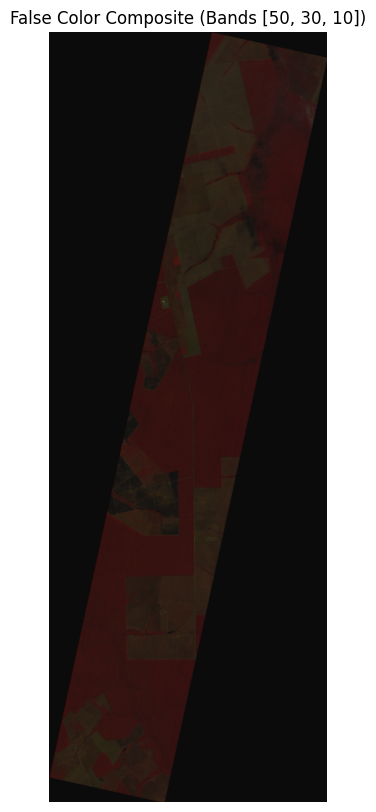

In [27]:
# --- Load Hyperspectral Image ---

# Use Hyperion image example to match wavebands with ISRIC-ICARF data
hdr_file = "tanguro_hyp_071004_bil_sub_acorn_refl_destrspline_geo.hdr"
bin_file = "tanguro_hyp_071004_bil_sub_acorn_refl_destrspline_geo.bin"

# Use ENVI reader to specify both header and data explicitly
img = envi.open(hdr_file, bin_file)
cube = img.load()  # shape: (rows, cols, bands)
print("Image shape:", cube.shape)

# Extract wavelengths from metadata
wavelengths = img.metadata.get("wavelength")

# If it's a list of strings, convert to float
if isinstance(wavelengths, list):
    wavelengths = [float(w) for w in wavelengths]

# Create a false color composite (adjust bands for your sensor)
rgb_bands = [50, 30, 10]  # Typical R=SWIR, G=NIR, B=Red for vegetation
rgb_img = img[:, :, rgb_bands]  # Extract RGB bands

# Scale to 0-1 range for display
rgb_img = (rgb_img - np.nanmin(rgb_img)) / (np.nanmax(rgb_img) - np.nanmin(rgb_img))

# Display
plt.figure(figsize=(10, 10))
plt.imshow(rgb_img)
plt.title('False Color Composite (Bands {})'.format(rgb_bands))
plt.axis('off')
plt.show()

In [28]:
# Load spectra data
spectra_df = pd.read_excel("Data.xlsx")
spectral_columns = [col for col in spectra_df.columns if col.startswith("W")]
asd_wavelengths = [int(col[1:]) for col in spectral_columns]  # Extract 350, 360, ..., 2500

spectra_df.head()

,Batch_Labid,W350,W360,W370,W380,W390,W400,W410,W420,W430,...,W2410,W2420,W2430,W2440,W2450,W2460,W2470,W2480,W2490,W2500
0,FS15R_FS4076,0.087266,0.072293,0.067882,0.071278,0.070909,0.075602,0.078873,0.082193,0.088196,...,0.394691,0.388342,0.378323,0.363642,0.355189,0.350998,0.347304,0.339293,0.336794,0.342761
1,FS15R_FS4077,0.091761,0.070821,0.069020,0.070133,0.072216,0.076107,0.079003,0.083118,0.089067,...,0.372140,0.364687,0.353332,0.338953,0.333400,0.325874,0.324145,0.326207,0.326426,0.330888
2,FS15R_FS4078,0.089091,0.069347,0.069658,0.068196,0.070051,0.071531,0.072116,0.075222,0.080212,...,0.317970,0.311350,0.300105,0.286625,0.280191,0.276309,0.276022,0.268724,0.279947,0.275649
3,FS15R_FS4079,0.094945,0.088997,0.081051,0.083512,0.085434,0.086396,0.087520,0.090224,0.095810,...,0.325006,0.316872,0.307036,0.291386,0.285994,0.280008,0.281164,0.280671,0.287855,0.290292
4,FS15R_FS4080,0.091239,0.065712,0.065946,0.066217,0.066276,0.064272,0.063520,0.065252,0.068709,...,0.369781,0.361111,0.348867,0.333307,0.325529,0.323597,0.323335,0.320587,0.325964,0.324467


In [29]:
# Create a new DataFrame to store interpolated spectra
interpolated_spectra = []

# Loop through each row of ASD spectra and interpolate
for _, row in spectra_df[spectral_columns].iterrows():
    original_values = row.values
    interpolated_values = np.interp(wavelengths, asd_wavelengths, original_values)
    interpolated_spectra.append(interpolated_values)

# Convert to DataFrame
interpolated_df = pd.DataFrame(interpolated_spectra, columns=[f"W{int(w)}" for w in wavelengths])

# Replace spectra_df's spectral columns with interpolated ones
spectra_df = pd.concat([spectra_df[["Batch_Labid"]], interpolated_df], axis=1)

spectra_df.head()

,Batch_Labid,W396,W406,W416,W426,W436,W447,W457,W467,W477,...,W2314,W2324,W2335,W2345,W2355,W2365,W2375,W2385,W2395,W2405
0,FS15R_FS4076,0.073861,0.077717,0.081077,0.086285,0.093424,0.099643,0.103594,0.105771,0.108426,...,0.419333,0.417151,0.417472,0.412291,0.404735,0.400416,0.392594,0.387951,0.392287,0.394914
1,FS15R_FS4077,0.074664,0.077979,0.081736,0.087173,0.094453,0.101311,0.105222,0.107484,0.110250,...,0.401735,0.398812,0.397866,0.391288,0.382867,0.377999,0.369754,0.364389,0.368251,0.371760
2,FS15R_FS4078,0.070982,0.071909,0.074179,0.078623,0.085064,0.091403,0.094853,0.096647,0.099036,...,0.354204,0.350083,0.348525,0.340768,0.331161,0.325054,0.315784,0.310430,0.314744,0.318004
3,FS15R_FS4079,0.086039,0.087122,0.089315,0.094031,0.101051,0.108373,0.113536,0.116739,0.120223,...,0.368258,0.363653,0.361029,0.351178,0.340446,0.334444,0.323777,0.316743,0.321095,0.324854
4,FS15R_FS4080,0.065015,0.063786,0.064670,0.067608,0.071901,0.076840,0.080478,0.082830,0.085303,...,0.410066,0.405319,0.403496,0.394688,0.383132,0.376132,0.365617,0.359302,0.364597,0.369204


In [30]:
# --- Load Soil Data ---

# Load soil reference data
soil_df = pd.read_csv("ICRAF_ISRIC reference data.csv")

# Rename key column to align
soil_df.rename(columns={"Batch and labid": "Batch_Labid"}, inplace=True)

# Merge on common key
merged_df = pd.merge(spectra_df, soil_df, on="Batch_Labid")

# --- Drop Nulls Only in Needed Columns ---

# Define spectral columns
spectral_columns = [col for col in merged_df.columns if col.startswith("W")]

# Drop rows with missing values only in Org C or spectral data
required_columns = ["Org C"] + spectral_columns
merged_df.dropna(subset=required_columns, inplace=True)

# Keep only spectral columns + Org C in merged_df
merged_df = merged_df[spectral_columns + ["Org C"]]

# --- Select Features and Target ---

# Spectral columns: wavelengths from 350nm to 2500nm
spectral_columns = [col for col in merged_df.columns if col.startswith("W")]
X = merged_df[spectral_columns]

# Target: Organic Carbon
y = merged_df["Org C"]

In [31]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3863 entries, 0 to 4239
Columns: 201 entries, W396 to Org C
dtypes: float64(201)
memory usage: 6.0 MB


In [32]:
merged_df.head()

,W396,W406,W416,W426,W436,W447,W457,W467,W477,W487,...,W2324,W2335,W2345,W2355,W2365,W2375,W2385,W2395,W2405,Org C
0,0.073861,0.077717,0.081077,0.086285,0.093424,0.099643,0.103594,0.105771,0.108426,0.113381,...,0.417151,0.417472,0.412291,0.404735,0.400416,0.392594,0.387951,0.392287,0.394914,0.99
1,0.074664,0.077979,0.081736,0.087173,0.094453,0.101311,0.105222,0.107484,0.110250,0.115258,...,0.398812,0.397866,0.391288,0.382867,0.377999,0.369754,0.364389,0.368251,0.371760,0.65
2,0.070982,0.071909,0.074179,0.078623,0.085064,0.091403,0.094853,0.096647,0.099036,0.103770,...,0.350083,0.348525,0.340768,0.331161,0.325054,0.315784,0.310430,0.314744,0.318004,0.46
3,0.086039,0.087122,0.089315,0.094031,0.101051,0.108373,0.113536,0.116739,0.120223,0.125402,...,0.363653,0.361029,0.351178,0.340446,0.334444,0.323777,0.316743,0.321095,0.324854,0.47
4,0.065015,0.063786,0.064670,0.067608,0.071901,0.076840,0.080478,0.082830,0.085303,0.089086,...,0.405319,0.403496,0.394688,0.383132,0.376132,0.365617,0.359302,0.364597,0.369204,0.19


In [34]:
print(f"Final dataset shape: {merged_df.shape}")
print(f"Number of spectral bands: {len(spectral_columns)}")

Final dataset shape: (3863, 201)
Number of spectral bands: 200


# Training and Evaluation

Train size: (3090, 200), Test size: (773, 200)
Selected 100 features from initial screening
Starting grid search...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters found:
{'dim_reduction__n_components': 0.95, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Cross-validated R²: 0.123 ± 0.375
Test R²: 0.486
Test RMSE: 1.560


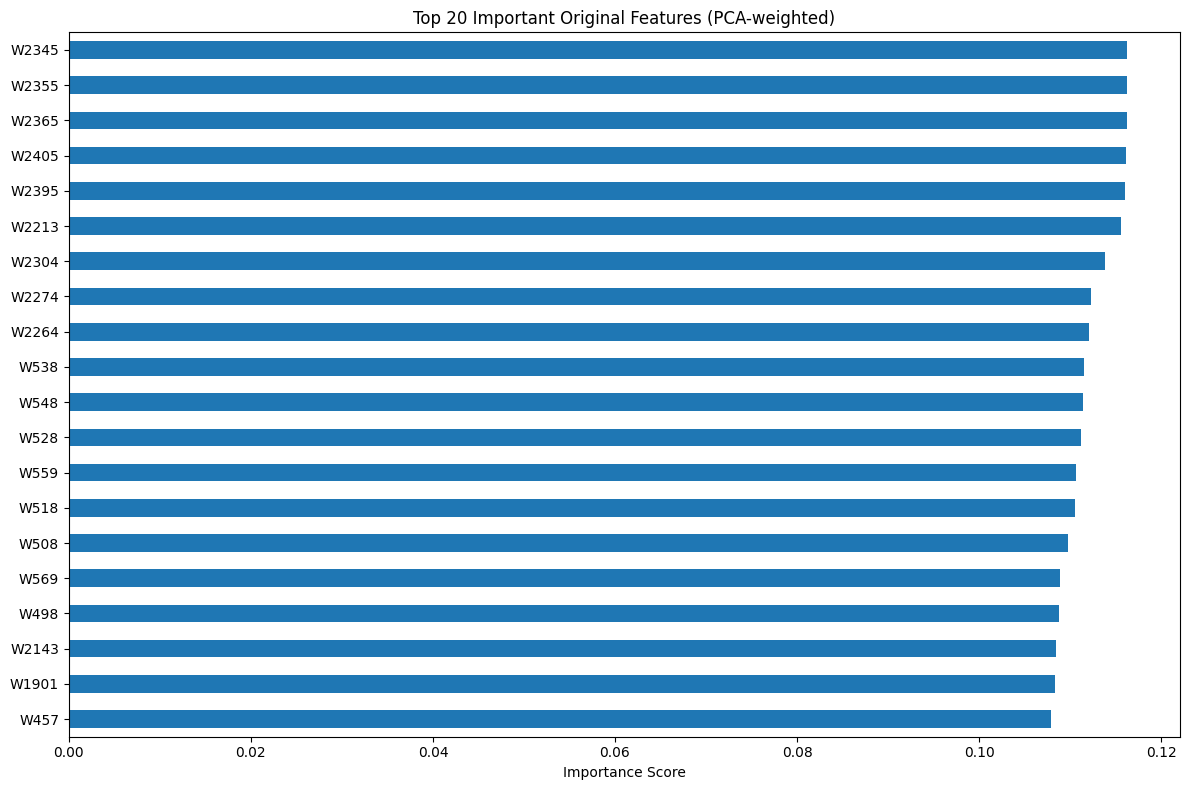

In [35]:
# --- Train-Test Split ---

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=pd.qcut(y, q=5)
)
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

# --- Feature Engineering ---

# Calculate spectral indices that might correlate with organic carbon
def add_spectral_indices(X):
    """Add common spectral indices relevant for soil organic carbon"""
    df = X.copy()
    wavelengths = [int(col[1:]) for col in X.columns if col.startswith('W')]
    
    # Normalized Difference Index (700, 1700 nm)
    if 'W700' in X.columns and 'W1700' in X.columns:
        df['NDI_700_1700'] = (X['W700'] - X['W1700']) / (X['W700'] + X['W1700'])
    
    # Simple Ratio (600, 2100 nm)
    if 'W600' in X.columns and 'W2100' in X.columns:
        df['SR_600_2100'] = X['W600'] / X['W2100']
    
    # Continuum Removal around 2200nm (clay minerals)
    if 'W2200' in X.columns:
        df['CR_2200'] = X['W2200'] / (0.5*(X['W2100'] + X['W2300']))
    
    return df

X_train = add_spectral_indices(X_train)
X_test = add_spectral_indices(X_test)

# --- Feature Selection ---

# Initial feature selection using Random Forest importance
initial_rf = RandomForestRegressor(n_estimators=100, random_state=42)
initial_rf.fit(X_train, y_train)

# Select top 30% most important features
selector = SelectFromModel(initial_rf, threshold='median')
selector.fit(X_train, y_train)
selected_features = X_train.columns[selector.get_support()]
print(f"Selected {len(selected_features)} features from initial screening")

X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

# --- Model Pipeline ---

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('transform', PowerTransformer()),  # Handle non-normal distributions
    ('dim_reduction', PCA(n_components=0.95)),  # Keep 95% variance
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# --- Hyperparameter Tuning ---

param_grid = {
    'dim_reduction__n_components': [0.85, 0.90, 0.95],
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5, 7],
    'regressor__min_samples_split': [2, 5],
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("Starting grid search...")
grid_search.fit(X_train_sel, y_train)
print("Best parameters found:")
print(grid_search.best_params_)

# --- Evaluation ---

best_model = grid_search.best_estimator_

# Cross-validated performance
cv_scores = cross_val_score(best_model, X_train_sel, y_train, cv=5, scoring='r2')
print(f"Cross-validated R²: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

# Test set performance
y_pred = best_model.predict(X_test_sel)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test R²: {r2:.3f}")
print(f"Test RMSE: {rmse:.3f}")

# --- Feature Importance Analysis (PCA back-projection) ---

try:
    pca = best_model.named_steps['dim_reduction']
    rf = best_model.named_steps['regressor']
    
    # PCA Components: shape (n_components, n_original_features)
    # RF Importances: shape (n_components,)
    # Multiply each component's contribution to each original feature
    # Weighted sum of |component loadings| * importance
    pca_components = np.abs(pca.components_)  # shape: (n_components, n_original_features)
    rf_importance = rf.feature_importances_   # shape: (n_components,)
    
    # Project importances back to original features
    # Final importance shape: (n_original_features,)
    feature_importance_values = np.dot(rf_importance, pca_components)
    
    feature_importance = pd.Series(
        feature_importance_values,
        index=selected_features
    ).sort_values(ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    feature_importance.head(20).plot.barh()
    plt.title('Top 20 Important Original Features (PCA-weighted)')
    plt.xlabel('Importance Score')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

except AttributeError:
    # Fallback if no PCA
    rf = best_model.named_steps['regressor']
    feature_importance = pd.Series(
        rf.feature_importances_,
        index=selected_features
    ).sort_values(ascending=False)
    
    plt.figure(figsize=(12, 8))
    feature_importance.head(20).plot.barh()
    plt.title('Top 20 Important Features')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

In [36]:
# --- Save Model ---
joblib.dump(best_model, 'optimized_soil_carbon_model.pkl')
joblib.dump(selector, 'feature_selector.pkl')
print("Model and feature selector saved successfully")

Model and feature selector saved successfully


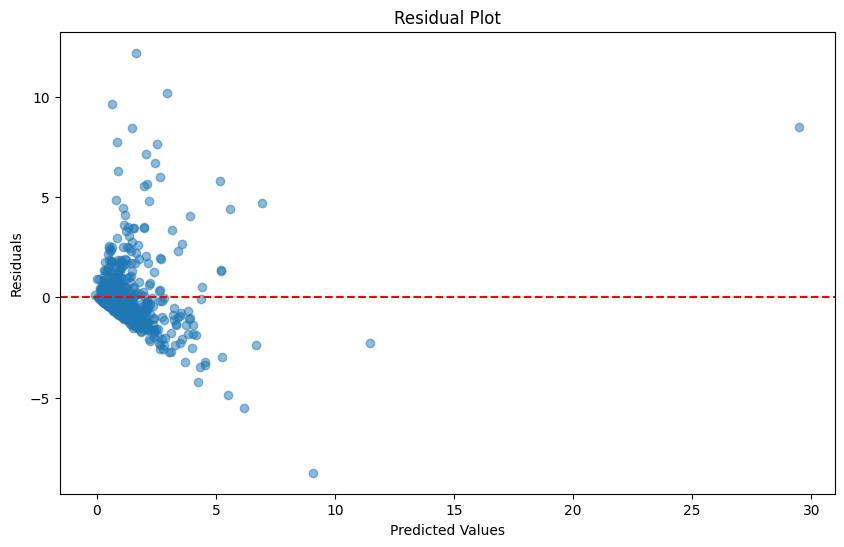

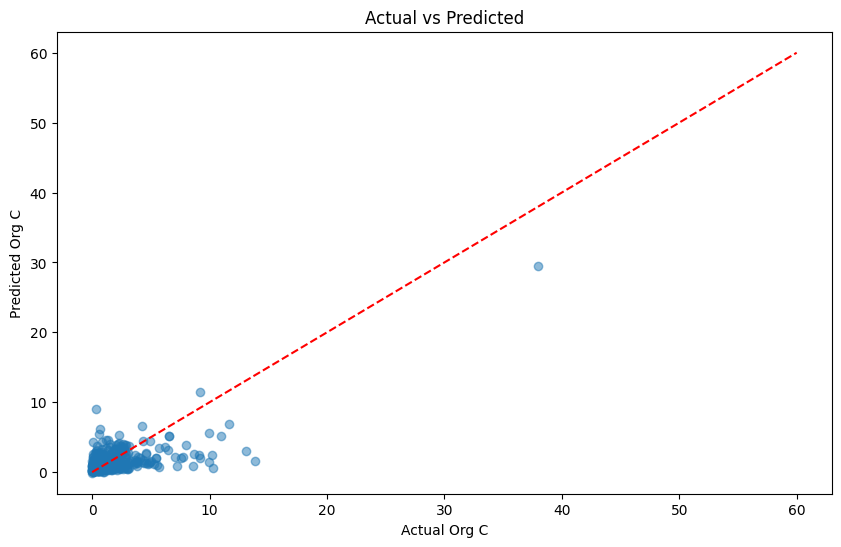

In [37]:
# --- Diagnostic Plots ---

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title('Actual vs Predicted')
plt.xlabel('Actual Org C')
plt.ylabel('Predicted Org C')
plt.show()

# Model Testing

In [1]:
import joblib

model = joblib.load('optimized_soil_carbon_model.pkl')
selector = joblib.load('feature_selector.pkl')

In [2]:
from spectral.io import envi

hdr_file = "tanguro_hyp_071004_bil_sub_acorn_refl_destrspline_geo.hdr"
bin_file = "tanguro_hyp_071004_bil_sub_acorn_refl_destrspline_geo.bin"

img = envi.open(hdr_file, bin_file)
cube = img.load()  # shape: (rows, cols, bands)
wavelengths = img.metadata.get("wavelength")
wavelengths = [float(w) for w in wavelengths]  # Ensure float


In [3]:
import numpy as np

rows, cols, bands = cube.shape
pixel_data = cube.reshape(-1, bands)  # shape: (num_pixels, bands)


In [4]:
import pandas as pd

band_names = [f"W{int(w)}" for w in wavelengths]
pixel_df = pd.DataFrame(pixel_data, columns=band_names)


In [5]:
def add_spectral_indices(X):
    df = X.copy()
    if 'W700' in df.columns and 'W1700' in df.columns:
        df['NDI_700_1700'] = (df['W700'] - df['W1700']) / (df['W700'] + df['W1700'])
    if 'W600' in df.columns and 'W2100' in df.columns:
        df['SR_600_2100'] = df['W600'] / df['W2100']
    if 'W2200' in df.columns:
        df['CR_2200'] = df['W2200'] / (0.5 * (df.get('W2100', 1) + df.get('W2300', 1)))
    return df

pixel_df = add_spectral_indices(pixel_df)


In [6]:
selected_columns = selector.get_support(indices=True)
selected_features = pixel_df.columns[selected_columns]
X_selected = pixel_df[selected_features]

In [7]:
y_pred_flat = model.predict(X_selected)

In [8]:
org_c_map = y_pred_flat.reshape(rows, cols)

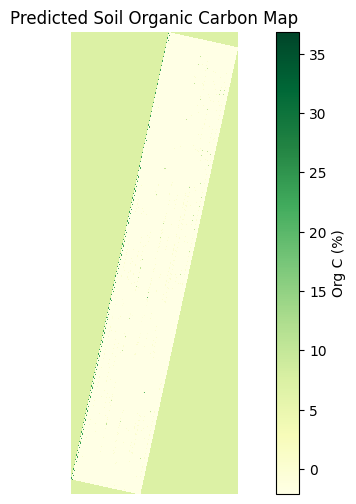

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.imshow(org_c_map, cmap='YlGn', interpolation='none')
plt.title("Predicted Soil Organic Carbon Map")
plt.colorbar(label='Org C (%)')
plt.axis('off')
plt.show()


In [25]:
row, col = 300, 300  # Example coordinates

# Get the pixel index in the flattened array
pixel_index = row * cols + col
value = y_pred_flat[pixel_index]

print(f"Predicted Soil Organic Carbon at ({row}, {col}): {value:.3f} %")

Predicted Soil Organic Carbon at (300, 300): 7.081 %


In [29]:
row, col = 500, 300  # Example coordinates

# Get the pixel index in the flattened array
pixel_index = row * cols + col
value = y_pred_flat[pixel_index]

print(f"Predicted Soil Organic Carbon at ({row}, {col}): {value:.3f} %")

Predicted Soil Organic Carbon at (500, 300): -2.092 %
